In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re

(2222, 39)
[[  0.00000000e+00  -1.31555600e+00   1.24605000e+00 ...,   2.83025210e+01
    2.00930222e+02  -5.71308716e+02]
 [  4.00000000e-02  -1.31405300e+00   1.24639600e+00 ...,   2.93572690e+01
    2.02336563e+02  -5.70638306e+02]
 [  8.00000000e-02  -1.31332300e+00   1.24730100e+00 ...,   2.95330660e+01
    2.03215515e+02  -5.71476257e+02]
 ..., 
 [  8.87600000e+01  -1.32042000e+00   1.21113600e+00 ...,   2.19739990e+01
    1.88273209e+02  -5.71643860e+02]
 [  8.88000000e+01  -1.33211500e+00   1.20731700e+00 ...,   2.09192500e+01
    1.88624786e+02  -5.71308716e+02]
 [  8.88400000e+01  -1.33694000e+00   1.20552400e+00 ...,   2.16224210e+01
    1.89327957e+02  -5.69632812e+02]]
(2222, 1)
[[0]
 [0]
 [0]
 ..., 
 [0]
 [0]
 [0]]


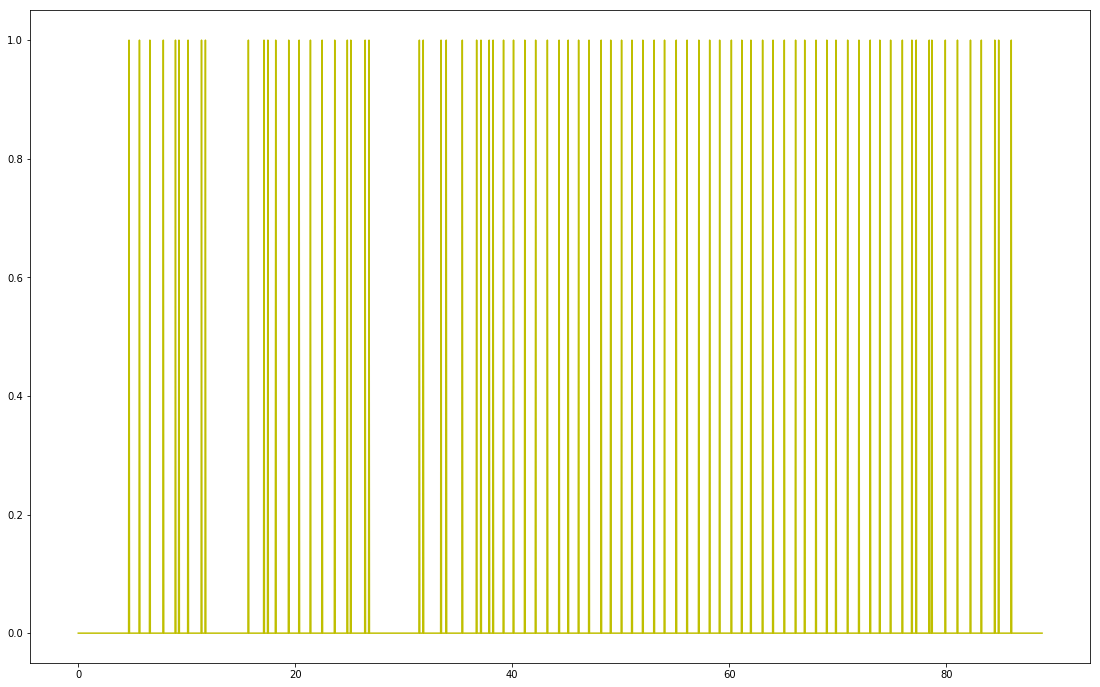

In [35]:
f_sensor=open('weallwalk/T1_ID1_1L_GD_iPhoneSensors.csv')  
dataset=pd.read_csv(f_sensor)
#dataset.head(10)

data_x = np.array(dataset.iloc[:, 0:39])
print(data_x.shape)
print(data_x)

data_y = np.array(dataset.iloc[:, 40:41])
data_y = np.array(data_y)
    
print data_y.shape
print data_y

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d  

plt.figure(figsize=(19, 12))
#plt.plot([i for i in range(0,1000)], [i[0] for i in rand_x], 'b')
plt.plot([i[0] for i in data_x], [i[0] for i in data_y], 'y')
plt.show()

<?xml version="1.0" encoding="UTF-8"?>
<root xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" x
134
134
134


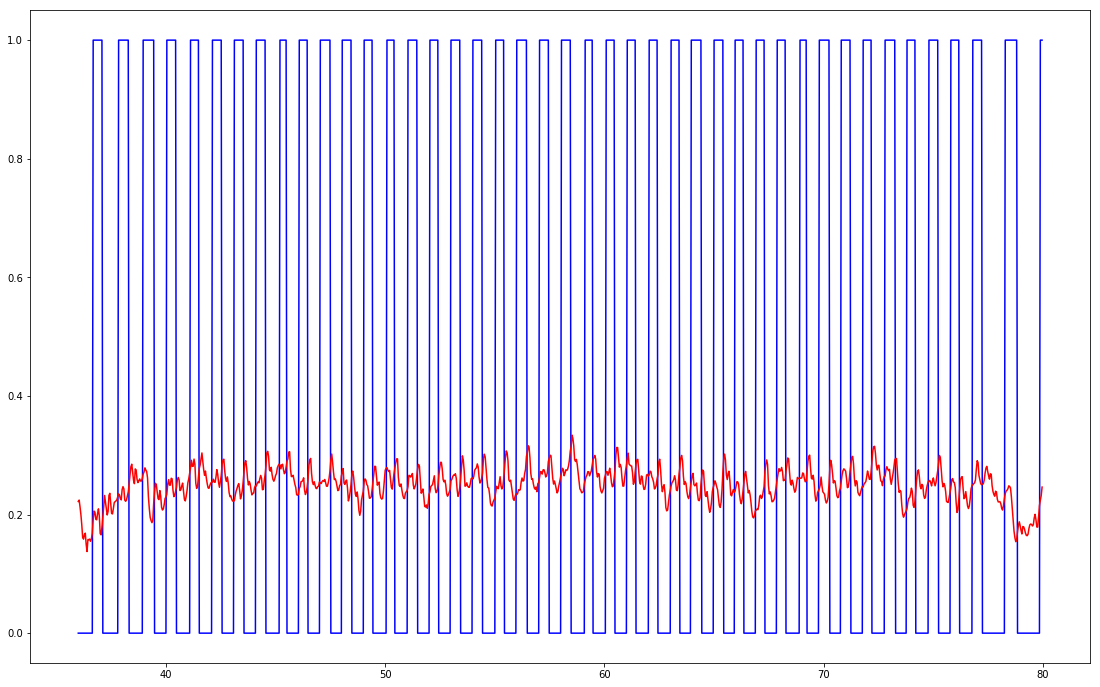

In [161]:
# slurp data
f = open('weallwalk/T1_ID1_GD.xml')
cts = f.read()
f.close()

print cts[0:100]

# capture type, language and feature
p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
all_foot = p_foot.findall(cts)
print len(all_foot)

p_time = re.compile(r'<Time>(.*?)</Time>')
all_time = p_time.findall(cts)
print len(all_time)

strike_times = []
for i in range(len(all_foot)):
    strike_times.append([float(all_time[i]), all_foot[i]])
#     print all_foot[i]
#     print float(all_time[i])

print len(strike_times)

# left - 0, right = 1
strike_times.append([len(data_x)/25.0, 'E'])
step_direct = 0
window_y = []
strike_index=0
for i in range(len(data_x)):
    if(strike_index<len(strike_times) and i/25.0 < strike_times[strike_index][0]):
        window_y.append([step_direct])
    else:
        step_direct = 1-step_direct
        strike_index += 1
        window_y.append([step_direct])
        
# print window_y
start=900
plt.figure(figsize=(19, 12))
#plt.plot([i[0] for i in data_x[1000:1500]], [i[0] for i in data_x[1000:1500]], 'y')
plt.plot([i[0] for i in data_x[start:2000]], [i[0] for i in window_y[start:2000]], 'b')
plt.plot([i[0] for i in data_x[start:2000]], [i[6] for i in data_x[start:2000]], 'r')
plt.show()

In [109]:
# Training Parameters
learning_rate = 0.5
training_steps = 10000
#batch_size = 128
display_step = 200

# Network Parameters
num_input = 39 # MNIST data input (img shape: 28*28)
timesteps = 20 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [193]:
# train_x = data_x[1000:1500]
# train_y = window_y[1000:1500]

train_x,train_y=[],[] 
for i in range(1000, 1500):
    x=data_x[i:i+timesteps]
    y=window_y[i+timesteps]
    train_x.append(x)
    train_y.append(y)

#print(train_x[0])
print(train_y[0])

[0]


In [204]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        print len(x)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        print outputs.shape
        outputs = tf.transpose(outputs, [1,0,2])
        print outputs.shape

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    print logits.shape
    print Y.shape
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

20
(?, 20, 100)
(20, ?, 100)
(?, 1)
(?, 1)


In [205]:
training_steps = 1001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(training_steps):
        feed_dict = {X: train_x, Y: train_y}
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 10 == 0):
            print('Loss at step %d: %f' % (step, l))

Initialized
Loss at step 0: 0.828213
Loss at step 10: 1.053808
Loss at step 20: 0.269119
Loss at step 30: 0.283763
Loss at step 40: 0.270959
Loss at step 50: 0.243379
Loss at step 60: 0.247391
Loss at step 70: 0.243301
Loss at step 80: 0.243677
Loss at step 90: 0.242254
Loss at step 100: 0.241419
Loss at step 110: 0.238049
Loss at step 120: 0.234592
Loss at step 130: 0.230685
Loss at step 140: 0.224392
Loss at step 150: 0.215957
Loss at step 160: 0.203590
Loss at step 170: 0.185436
Loss at step 180: 0.161983
Loss at step 190: 0.140810
Loss at step 200: 0.125803
Loss at step 210: 0.120040
Loss at step 220: 0.112304
Loss at step 230: 0.121793
Loss at step 240: 0.108937
Loss at step 250: 0.106342
Loss at step 260: 0.102400
Loss at step 270: 0.099523
Loss at step 280: 0.103037
Loss at step 290: 0.094423
Loss at step 300: 0.090251
Loss at step 310: 0.086625
Loss at step 320: 0.084356
Loss at step 330: 0.083716
Loss at step 340: 0.078978
Loss at step 350: 0.077557
Loss at step 360: 0.085341


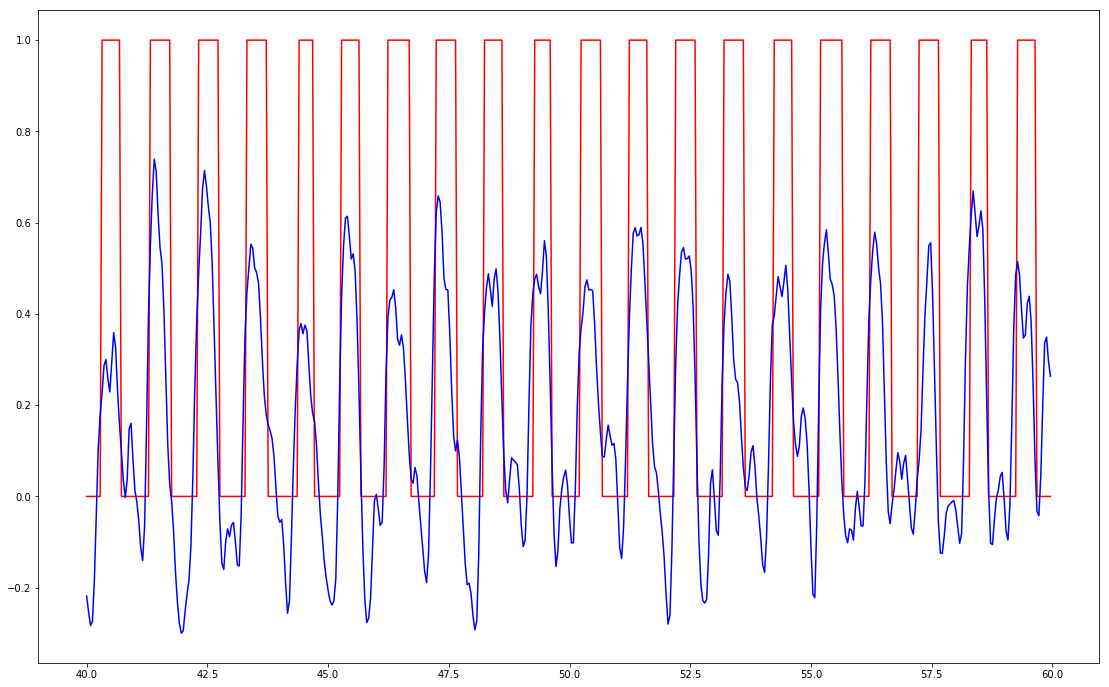

In [206]:
plt.figure(figsize=(19, 12))
plt.plot([i[0][0] for i in train_x], [i[0] for i in train_y], 'r')
plt.plot([i[0][0] for i in train_x], [i[0] for i in predictions], 'b')
plt.show()